In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
import kornia as K

# img = plt.imread('bowl-of-fruit.jpg')
# t_rgb: torch.tensor = K.image_to_tensor(img)
# t_rgb = t_rgb.unsqueeze(0)
# img_rgb: np.array = K.tensor_to_image(t_rgb)
# plt.imshow(img_rgb)

### 1. Canny edge detection Q1

In [8]:
def MyCanny(img, sigma, t_ratio):
    #convert image to tensors
    t_rgb: torch.tensor = K.image_to_tensor(img)
    t_rgb = t_rgb.unsqueeze(0)
    img_rgb: np.array = K.tensor_to_image(t_rgb)
    #get the grayscale tensor
    t_g = K.color.rgb_to_grayscale(t_rgb.float())
    img_g: np.array = K.tensor_to_image(t_g)
    #implement guassian blur
    t_blur = K.filters.gaussian_blur2d(t_g, (3, 3), (sigma, sigma))
    img_blur: np.array = K.tensor_to_image(t_blur)
    #take the first derivative with respect to x, y, and flip the kernel
    sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]])
    sobel_xf = sobel_x.expand(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]])
    sobel_yf = sobel_y.expand(1, 1, 3, 3)
    #Do convolution with the sobel filters
    x_conv = torch.conv2d(t_blur.float(), sobel_xf)
    img_convx: np.array = K.tensor_to_image(x_conv)
    y_conv = torch.conv2d(t_blur.float(), sobel_yf)
    img_convy: np.array = K.tensor_to_image(y_conv)
    #get the gradient magnitude
    t_mag = torch.sqrt(torch.pow(x_conv, 2) + torch.pow(y_conv, 2))
    img_mag: np.array = K.tensor_to_image(t_mag)
    #calculate the orientation of magnitude
    t_ori = torch.atan2(y_conv, x_conv)
    img_ori: np.array = K.tensor_to_image(t_ori)
        
    width = img_mag.shape[0]
    length = img_mag.shape[1]
    img_sup = np.zeros((width, length), dtype = np.float32)

    theta = img_ori
    theta[img_ori < 0] += np.pi

    #divdes into six regions
    for w in range(1, width - 1):
        for l in range(1, length - 1):
            nei_1 = 0 #neighbor 1
            nei_2 = 0 #neighbor 2
            
            if(0 <= theta[w, l] and theta[w, l] < (np.pi/8)):
                nei_1 = img_mag[w, l + 1]
                nei_2 = img_mag[w, l - 1]
            elif((np.pi / 8) <= theta[w, l] and theta[w, l] < (3 * np.pi / 8)):
                nei_1 = img_mag[w + 1, l - 1]
                nei_2 = img_mag[w - 1, l + 1]
            elif((3 * np.pi / 8) <= theta[w, l] and theta[w, l] < (4 * np.pi / 8)):
                nei_1 = img_mag[w + 1, l]
                nei_2 = img_mag[w - 1, l]
            elif((4 * np.pi / 8) <= theta[w, l] and theta[w, l] < (5 * np.pi / 8)):
                nei_1 = img_mag[w - 1, l - 1]
                nei_2 = img_mag[w + 1, l + 1]
            elif((5 * np.pi / 8) <= theta[w, l] and theta[w, l] < (np.pi)):
                nei_1 = img_mag[w, l + 1]
                nei_2 = img_mag[w, l - 1]
            if(img_mag[w, l] >= nei_1) and (img_mag[w, l] >= nei_2):
                img_sup[w, l] = img_mag[w, l]
            else:
                img_sup[w, l] = 0
    ratio_t = t_ratio #threshold ratio
    threshold = ratio_t * np.amax(img_mag)
    output = np.zeros((width, length))
    #assign intencity to the signal entry
    output[img_sup > threshold] = 1
    return output

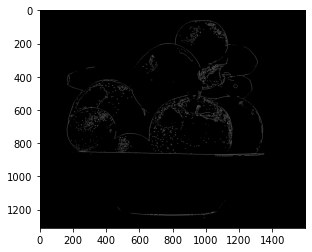

In [9]:
img = plt.imread('bowl-of-fruit.jpg')
sigma = 5.
t_ratio = 0.1 
img_temp = MyCanny(img, sigma, t_ratio) 
# input parameters: image matrix, standard deviation for gaussian blur(float), threshold ratio 
plt.imshow(img_temp, cmap = 'gray')
plt.imsave('myCanny.jpg', img_temp, cmap = 'gray')

In [108]:
def MyCannyFull(img, sigma, h_ratio, l_ratio):
    #mostly the same from MyCanny
    t_rgb: torch.tensor = K.image_to_tensor(img)
    t_rgb = t_rgb.unsqueeze(0)
    img_rgb: np.array = K.tensor_to_image(t_rgb)
    t_g = K.color.rgb_to_grayscale(t_rgb.float())
    img_g: np.array = K.tensor_to_image(t_g)
    t_blur = K.filters.gaussian_blur2d(t_g, (3, 3), (sigma, sigma))
    img_blur: np.array = K.tensor_to_image(t_blur)
    sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]])
    sobel_xf = sobel_x.expand(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]])
    sobel_yf = sobel_y.expand(1, 1, 3, 3)
    x_conv = torch.conv2d(t_blur.float(), sobel_xf)
    img_convx: np.array = K.tensor_to_image(x_conv)
    y_conv = torch.conv2d(t_blur.float(), sobel_yf)
    img_convy: np.array = K.tensor_to_image(y_conv)
    t_mag = torch.sqrt(torch.pow(x_conv, 2) + torch.pow(y_conv, 2))
    img_mag: np.array = K.tensor_to_image(t_mag)
    t_ori = torch.atan2(y_conv, x_conv)
    img_ori: np.array = K.tensor_to_image(t_ori)
    width = img_mag.shape[0]
    length = img_mag.shape[1]
    img_sup = np.zeros((width, length), dtype = np.float32)

    theta = img_ori
    theta[img_ori < 0] += np.pi

    #divdes into eight directions
    for w in range(1, width - 1):
        for l in range(1, length - 1):
            nei_1 = 0
            nei_2 = 0
        
            if(0 <= theta[w, l] and theta[w, l] < (np.pi/8)):
                nei_1 = img_mag[w, l + 1]
                nei_2 = img_mag[w, l - 1]
            elif((np.pi/8) <= theta[w, l] and theta[w, l] < (3*np.pi/8)):
                nei_1 = img_mag[w + 1, l - 1]
                nei_2 = img_mag[w - 1, l + 1]
            elif((3*np.pi/8) <= theta[w, l] and theta[w, l] < (4*np.pi/8)):
                nei_1 = img_mag[w + 1, l]
                nei_2 = img_mag[w - 1, l]
            elif((4*np.pi/8) <= theta[w, l] and theta[w, l] < (5*np.pi/8)):
                nei_1 = img_mag[w - 1, l - 1]
                nei_2 = img_mag[w + 1, l + 1]
            elif((5*np.pi/8) <= theta[w, l] and theta[w, l] < (np.pi)):
                nei_1 = img_mag[w, l + 1]
                nei_2 = img_mag[w, l - 1]
            if(img_mag[w, l] >= nei_1) and (img_mag[w, l] >= nei_2):
                img_sup[w, l] = img_mag[w, l]
            else:
                img_sup[w, l] = 0
                
    output = np.zeros((width, length))
    ratio_l = l_ratio #threshold ratio
    threshold_l = ratio_l * np.amax(img_mag)
    #assign intencity to the signal entry
    output[img_sup > threshold_l] = 1 #high intensity
    
    ratio_h = h_ratio #threshold ratio
    threshold_h = ratio_h * np.amax(img_mag)
    #assign intencity to the signal entry
    output[img_sup > threshold_h] = 2 #high intensity
    
    linked = np.zeros((w, l))
        
    for w in range(0, width - 1):
        for l in range(0, length - 1):
            output, linked = check(output, w, l, linked)   
    return output

In [109]:
def check(output, w, l, linked):
    if(output[w, l] == 2 and linked[w, l] == 0):
        nei = np.array([[w + 1, l + 1], [w - 1, l + 1], [w + 1, l - 1], 
               [w - 1, l - 1], [w, l + 1], [w + 1, l], [w - 1, l], [w, l - 1]])
        print(nei)
        linked[w, l] = 1
        for i in range(0, 8):
            if output[nei[i][0], nei[i][1]] == 1:
                output[nei[i][0], nei[i][1]] = 2
                check(output, nei[i][0], nei[i][1], linked)
            else:
                output[w, l] = 0
    return output, linked
    

[[ 64 949]
 [ 62 949]
 [ 64 947]
 [ 62 947]
 [ 63 949]
 [ 64 948]
 [ 62 948]
 [ 63 947]]
[[ 64 950]
 [ 62 950]
 [ 64 948]
 [ 62 948]
 [ 63 950]
 [ 64 949]
 [ 62 949]
 [ 63 948]]
[[ 64 982]
 [ 62 982]
 [ 64 980]
 [ 62 980]
 [ 63 982]
 [ 64 981]
 [ 62 981]
 [ 63 980]]
[[ 64 983]
 [ 62 983]
 [ 64 981]
 [ 62 981]
 [ 63 983]
 [ 64 982]
 [ 62 982]
 [ 63 981]]
[[ 64 984]
 [ 62 984]
 [ 64 982]
 [ 62 982]
 [ 63 984]
 [ 64 983]
 [ 62 983]
 [ 63 982]]
[[ 64 985]
 [ 62 985]
 [ 64 983]
 [ 62 983]
 [ 63 985]
 [ 64 984]
 [ 62 984]
 [ 63 983]]
[[ 64 986]
 [ 62 986]
 [ 64 984]
 [ 62 984]
 [ 63 986]
 [ 64 985]
 [ 62 985]
 [ 63 984]]
[[ 64 987]
 [ 62 987]
 [ 64 985]
 [ 62 985]
 [ 63 987]
 [ 64 986]
 [ 62 986]
 [ 63 985]]
[[ 64 988]
 [ 62 988]
 [ 64 986]
 [ 62 986]
 [ 63 988]
 [ 64 987]
 [ 62 987]
 [ 63 986]]
[[ 64 989]
 [ 62 989]
 [ 64 987]
 [ 62 987]
 [ 63 989]
 [ 64 988]
 [ 62 988]
 [ 63 987]]
[[ 64 990]
 [ 62 990]
 [ 64 988]
 [ 62 988]
 [ 63 990]
 [ 64 989]
 [ 62 989]
 [ 63 988]]
[[ 64 991]
 [ 62 991]

 [142 914]]
[[143 920]
 [141 920]
 [143 918]
 [141 918]
 [142 920]
 [143 919]
 [141 919]
 [142 918]]
[[143 923]
 [141 923]
 [143 921]
 [141 921]
 [142 923]
 [143 922]
 [141 922]
 [142 921]]
[[143 928]
 [141 928]
 [143 926]
 [141 926]
 [142 928]
 [143 927]
 [141 927]
 [142 926]]
[[143 944]
 [141 944]
 [143 942]
 [141 942]
 [142 944]
 [143 943]
 [141 943]
 [142 942]]
[[ 143 1047]
 [ 141 1047]
 [ 143 1045]
 [ 141 1045]
 [ 142 1047]
 [ 143 1046]
 [ 141 1046]
 [ 142 1045]]
[[ 143 1048]
 [ 141 1048]
 [ 143 1046]
 [ 141 1046]
 [ 142 1048]
 [ 143 1047]
 [ 141 1047]
 [ 142 1046]]
[[ 143 1050]
 [ 141 1050]
 [ 143 1048]
 [ 141 1048]
 [ 142 1050]
 [ 143 1049]
 [ 141 1049]
 [ 142 1048]]
[[ 144 1050]
 [ 142 1050]
 [ 144 1048]
 [ 142 1048]
 [ 143 1050]
 [ 144 1049]
 [ 142 1049]
 [ 143 1048]]
[[ 143 1072]
 [ 141 1072]
 [ 143 1070]
 [ 141 1070]
 [ 142 1072]
 [ 143 1071]
 [ 141 1071]
 [ 142 1070]]
[[ 143 1075]
 [ 141 1075]
 [ 143 1073]
 [ 141 1073]
 [ 142 1075]
 [ 143 1074]
 [ 141 1074]
 [ 142 1073]]
[[

 [178 909]]
[[179 912]
 [177 912]
 [179 910]
 [177 910]
 [178 912]
 [179 911]
 [177 911]
 [178 910]]
[[179 916]
 [177 916]
 [179 914]
 [177 914]
 [178 916]
 [179 915]
 [177 915]
 [178 914]]
[[178 916]
 [176 916]
 [178 914]
 [176 914]
 [177 916]
 [178 915]
 [176 915]
 [177 914]]
[[179 923]
 [177 923]
 [179 921]
 [177 921]
 [178 923]
 [179 922]
 [177 922]
 [178 921]]
[[179 924]
 [177 924]
 [179 922]
 [177 922]
 [178 924]
 [179 923]
 [177 923]
 [178 922]]
[[179 928]
 [177 928]
 [179 926]
 [177 926]
 [178 928]
 [179 927]
 [177 927]
 [178 926]]
[[ 179 1120]
 [ 177 1120]
 [ 179 1118]
 [ 177 1118]
 [ 178 1120]
 [ 179 1119]
 [ 177 1119]
 [ 178 1118]]
[[ 179 1125]
 [ 177 1125]
 [ 179 1123]
 [ 177 1123]
 [ 178 1125]
 [ 179 1124]
 [ 177 1124]
 [ 178 1123]]
[[180 815]
 [178 815]
 [180 813]
 [178 813]
 [179 815]
 [180 814]
 [178 814]
 [179 813]]
[[180 890]
 [178 890]
 [180 888]
 [178 888]
 [179 890]
 [180 889]
 [178 889]
 [179 888]]
[[180 889]
 [178 889]
 [180 887]
 [178 887]
 [179 889]
 [180 888]


 [240 662]]
[[241 665]
 [239 665]
 [241 663]
 [239 663]
 [240 665]
 [241 664]
 [239 664]
 [240 663]]
[[241 837]
 [239 837]
 [241 835]
 [239 835]
 [240 837]
 [241 836]
 [239 836]
 [240 835]]
[[241 857]
 [239 857]
 [241 855]
 [239 855]
 [240 857]
 [241 856]
 [239 856]
 [240 855]]
[[241 867]
 [239 867]
 [241 865]
 [239 865]
 [240 867]
 [241 866]
 [239 866]
 [240 865]]
[[242 866]
 [240 866]
 [242 864]
 [240 864]
 [241 866]
 [242 865]
 [240 865]
 [241 864]]
[[240 866]
 [238 866]
 [240 864]
 [238 864]
 [239 866]
 [240 865]
 [238 865]
 [239 864]]
[[241 886]
 [239 886]
 [241 884]
 [239 884]
 [240 886]
 [241 885]
 [239 885]
 [240 884]]
[[ 241 1122]
 [ 239 1122]
 [ 241 1120]
 [ 239 1120]
 [ 240 1122]
 [ 241 1121]
 [ 239 1121]
 [ 240 1120]]
[[ 241 1261]
 [ 239 1261]
 [ 241 1259]
 [ 239 1259]
 [ 240 1261]
 [ 241 1260]
 [ 239 1260]
 [ 240 1259]]
[[242 838]
 [240 838]
 [242 836]
 [240 836]
 [241 838]
 [242 837]
 [240 837]
 [241 836]]
[[242 868]
 [240 868]
 [242 866]
 [240 866]
 [241 868]
 [242 867]


 [ 306 1122]]
[[ 307 1306]
 [ 305 1306]
 [ 307 1304]
 [ 305 1304]
 [ 306 1306]
 [ 307 1305]
 [ 305 1305]
 [ 306 1304]]
[[308 660]
 [306 660]
 [308 658]
 [306 658]
 [307 660]
 [308 659]
 [306 659]
 [307 658]]
[[308 668]
 [306 668]
 [308 666]
 [306 666]
 [307 668]
 [308 667]
 [306 667]
 [307 666]]
[[308 674]
 [306 674]
 [308 672]
 [306 672]
 [307 674]
 [308 673]
 [306 673]
 [307 672]]
[[309 673]
 [307 673]
 [309 671]
 [307 671]
 [308 673]
 [309 672]
 [307 672]
 [308 671]]
[[308 678]
 [306 678]
 [308 676]
 [306 676]
 [307 678]
 [308 677]
 [306 677]
 [307 676]]
[[309 677]
 [307 677]
 [309 675]
 [307 675]
 [308 677]
 [309 676]
 [307 676]
 [308 675]]
[[308 912]
 [306 912]
 [308 910]
 [306 910]
 [307 912]
 [308 911]
 [306 911]
 [307 910]]
[[308 945]
 [306 945]
 [308 943]
 [306 943]
 [307 945]
 [308 944]
 [306 944]
 [307 943]]
[[ 308 1051]
 [ 306 1051]
 [ 308 1049]
 [ 306 1049]
 [ 307 1051]
 [ 308 1050]
 [ 306 1050]
 [ 307 1049]]
[[ 308 1052]
 [ 306 1052]
 [ 308 1050]
 [ 306 1050]
 [ 307 1052]

 [352 261]]
[[350 280]
 [348 280]
 [350 278]
 [348 278]
 [349 280]
 [350 279]
 [348 279]
 [349 278]]
[[350 281]
 [348 281]
 [350 279]
 [348 279]
 [349 281]
 [350 280]
 [348 280]
 [349 279]]
[[350 282]
 [348 282]
 [350 280]
 [348 280]
 [349 282]
 [350 281]
 [348 281]
 [349 280]]
[[350 283]
 [348 283]
 [350 281]
 [348 281]
 [349 283]
 [350 282]
 [348 282]
 [349 281]]
[[350 284]
 [348 284]
 [350 282]
 [348 282]
 [349 284]
 [350 283]
 [348 283]
 [349 282]]
[[350 285]
 [348 285]
 [350 283]
 [348 283]
 [349 285]
 [350 284]
 [348 284]
 [349 283]]
[[350 286]
 [348 286]
 [350 284]
 [348 284]
 [349 286]
 [350 285]
 [348 285]
 [349 284]]
[[350 287]
 [348 287]
 [350 285]
 [348 285]
 [349 287]
 [350 286]
 [348 286]
 [349 285]]
[[ 350 1018]
 [ 348 1018]
 [ 350 1016]
 [ 348 1016]
 [ 349 1018]
 [ 350 1017]
 [ 348 1017]
 [ 349 1016]]
[[ 350 1036]
 [ 348 1036]
 [ 350 1034]
 [ 348 1034]
 [ 349 1036]
 [ 350 1035]
 [ 348 1035]
 [ 349 1034]]
[[ 350 1046]
 [ 348 1046]
 [ 350 1044]
 [ 348 1044]
 [ 349 1046]
 

 [ 376 1123]]
[[ 377 1268]
 [ 375 1268]
 [ 377 1266]
 [ 375 1266]
 [ 376 1268]
 [ 377 1267]
 [ 375 1267]
 [ 376 1266]]
[[378 196]
 [376 196]
 [378 194]
 [376 194]
 [377 196]
 [378 195]
 [376 195]
 [377 194]]
[[378 195]
 [376 195]
 [378 193]
 [376 193]
 [377 195]
 [378 194]
 [376 194]
 [377 193]]
[[378 194]
 [376 194]
 [378 192]
 [376 192]
 [377 194]
 [378 193]
 [376 193]
 [377 192]]
[[378 197]
 [376 197]
 [378 195]
 [376 195]
 [377 197]
 [378 196]
 [376 196]
 [377 195]]
[[378 950]
 [376 950]
 [378 948]
 [376 948]
 [377 950]
 [378 949]
 [376 949]
 [377 948]]
[[378 955]
 [376 955]
 [378 953]
 [376 953]
 [377 955]
 [378 954]
 [376 954]
 [377 953]]
[[379 954]
 [377 954]
 [379 952]
 [377 952]
 [378 954]
 [379 953]
 [377 953]
 [378 952]]
[[378 958]
 [376 958]
 [378 956]
 [376 956]
 [377 958]
 [378 957]
 [376 957]
 [377 956]]
[[378 969]
 [376 969]
 [378 967]
 [376 967]
 [377 969]
 [378 968]
 [376 968]
 [377 967]]
[[377 969]
 [375 969]
 [377 967]
 [375 967]
 [376 969]
 [377 968]
 [375 968]
 [3

 [406 950]]
[[407 957]
 [405 957]
 [407 955]
 [405 955]
 [406 957]
 [407 956]
 [405 956]
 [406 955]]
[[407 963]
 [405 963]
 [407 961]
 [405 961]
 [406 963]
 [407 962]
 [405 962]
 [406 961]]
[[407 977]
 [405 977]
 [407 975]
 [405 975]
 [406 977]
 [407 976]
 [405 976]
 [406 975]]
[[407 979]
 [405 979]
 [407 977]
 [405 977]
 [406 979]
 [407 978]
 [405 978]
 [406 977]]
[[407 989]
 [405 989]
 [407 987]
 [405 987]
 [406 989]
 [407 988]
 [405 988]
 [406 987]]
[[ 407 1006]
 [ 405 1006]
 [ 407 1004]
 [ 405 1004]
 [ 406 1006]
 [ 407 1005]
 [ 405 1005]
 [ 406 1004]]
[[ 407 1080]
 [ 405 1080]
 [ 407 1078]
 [ 405 1078]
 [ 406 1080]
 [ 407 1079]
 [ 405 1079]
 [ 406 1078]]
[[ 408 1080]
 [ 406 1080]
 [ 408 1078]
 [ 406 1078]
 [ 407 1080]
 [ 408 1079]
 [ 406 1079]
 [ 407 1078]]
[[ 406 1080]
 [ 404 1080]
 [ 406 1078]
 [ 404 1078]
 [ 405 1080]
 [ 406 1079]
 [ 404 1079]
 [ 405 1078]]
[[ 405 1079]
 [ 403 1079]
 [ 405 1077]
 [ 403 1077]
 [ 404 1079]
 [ 405 1078]
 [ 403 1078]
 [ 404 1077]]
[[ 404 1078]
 [ 40

 [ 438 1049]]
[[ 439 1054]
 [ 437 1054]
 [ 439 1052]
 [ 437 1052]
 [ 438 1054]
 [ 439 1053]
 [ 437 1053]
 [ 438 1052]]
[[ 438 1054]
 [ 436 1054]
 [ 438 1052]
 [ 436 1052]
 [ 437 1054]
 [ 438 1053]
 [ 436 1053]
 [ 437 1052]]
[[ 439 1089]
 [ 437 1089]
 [ 439 1087]
 [ 437 1087]
 [ 438 1089]
 [ 439 1088]
 [ 437 1088]
 [ 438 1087]]
[[ 439 1092]
 [ 437 1092]
 [ 439 1090]
 [ 437 1090]
 [ 438 1092]
 [ 439 1091]
 [ 437 1091]
 [ 438 1090]]
[[ 439 1093]
 [ 437 1093]
 [ 439 1091]
 [ 437 1091]
 [ 438 1093]
 [ 439 1092]
 [ 437 1092]
 [ 438 1091]]
[[ 439 1094]
 [ 437 1094]
 [ 439 1092]
 [ 437 1092]
 [ 438 1094]
 [ 439 1093]
 [ 437 1093]
 [ 438 1092]]
[[ 439 1095]
 [ 437 1095]
 [ 439 1093]
 [ 437 1093]
 [ 438 1095]
 [ 439 1094]
 [ 437 1094]
 [ 438 1093]]
[[ 439 1096]
 [ 437 1096]
 [ 439 1094]
 [ 437 1094]
 [ 438 1096]
 [ 439 1095]
 [ 437 1095]
 [ 438 1094]]
[[ 439 1267]
 [ 437 1267]
 [ 439 1265]
 [ 437 1265]
 [ 438 1267]
 [ 439 1266]
 [ 437 1266]
 [ 438 1265]]
[[440 166]
 [438 166]
 [440 164]
 [438 16

 [468 991]]
[[469 994]
 [467 994]
 [469 992]
 [467 992]
 [468 994]
 [469 993]
 [467 993]
 [468 992]]
[[469 995]
 [467 995]
 [469 993]
 [467 993]
 [468 995]
 [469 994]
 [467 994]
 [468 993]]
[[469 996]
 [467 996]
 [469 994]
 [467 994]
 [468 996]
 [469 995]
 [467 995]
 [468 994]]
[[469 997]
 [467 997]
 [469 995]
 [467 995]
 [468 997]
 [469 996]
 [467 996]
 [468 995]]
[[469 998]
 [467 998]
 [469 996]
 [467 996]
 [468 998]
 [469 997]
 [467 997]
 [468 996]]
[[469 999]
 [467 999]
 [469 997]
 [467 997]
 [468 999]
 [469 998]
 [467 998]
 [468 997]]
[[ 469 1000]
 [ 467 1000]
 [ 469  998]
 [ 467  998]
 [ 468 1000]
 [ 469  999]
 [ 467  999]
 [ 468  998]]
[[ 468 1001]
 [ 466 1001]
 [ 468  999]
 [ 466  999]
 [ 467 1001]
 [ 468 1000]
 [ 466 1000]
 [ 467  999]]
[[ 468 1002]
 [ 466 1002]
 [ 468 1000]
 [ 466 1000]
 [ 467 1002]
 [ 468 1001]
 [ 466 1001]
 [ 467 1000]]
[[ 468 1003]
 [ 466 1003]
 [ 468 1001]
 [ 466 1001]
 [ 467 1003]
 [ 468 1002]
 [ 466 1002]
 [ 467 1001]]
[[ 468 1004]
 [ 466 1004]
 [ 468 1

[[509 956]
 [507 956]
 [509 954]
 [507 954]
 [508 956]
 [509 955]
 [507 955]
 [508 954]]
[[509 963]
 [507 963]
 [509 961]
 [507 961]
 [508 963]
 [509 962]
 [507 962]
 [508 961]]
[[ 509 1123]
 [ 507 1123]
 [ 509 1121]
 [ 507 1121]
 [ 508 1123]
 [ 509 1122]
 [ 507 1122]
 [ 508 1121]]
[[510 264]
 [508 264]
 [510 262]
 [508 262]
 [509 264]
 [510 263]
 [508 263]
 [509 262]]
[[510 399]
 [508 399]
 [510 397]
 [508 397]
 [509 399]
 [510 398]
 [508 398]
 [509 397]]
[[511 399]
 [509 399]
 [511 397]
 [509 397]
 [510 399]
 [511 398]
 [509 398]
 [510 397]]
[[510 405]
 [508 405]
 [510 403]
 [508 403]
 [509 405]
 [510 404]
 [508 404]
 [509 403]]
[[510 562]
 [508 562]
 [510 560]
 [508 560]
 [509 562]
 [510 561]
 [508 561]
 [509 560]]
[[510 955]
 [508 955]
 [510 953]
 [508 953]
 [509 955]
 [510 954]
 [508 954]
 [509 953]]
[[510 963]
 [508 963]
 [510 961]
 [508 961]
 [509 963]
 [510 962]
 [508 962]
 [509 961]]
[[ 510 1125]
 [ 508 1125]
 [ 510 1123]
 [ 508 1123]
 [ 509 1125]
 [ 510 1124]
 [ 508 1124]
 [ 

 [537 243]]
[[537 382]
 [535 382]
 [537 380]
 [535 380]
 [536 382]
 [537 381]
 [535 381]
 [536 380]]
[[537 391]
 [535 391]
 [537 389]
 [535 389]
 [536 391]
 [537 390]
 [535 390]
 [536 389]]
[[538 391]
 [536 391]
 [538 389]
 [536 389]
 [537 391]
 [538 390]
 [536 390]
 [537 389]]
[[536 391]
 [534 391]
 [536 389]
 [534 389]
 [535 391]
 [536 390]
 [534 390]
 [535 389]]
[[537 464]
 [535 464]
 [537 462]
 [535 462]
 [536 464]
 [537 463]
 [535 463]
 [536 462]]
[[537 465]
 [535 465]
 [537 463]
 [535 463]
 [536 465]
 [537 464]
 [535 464]
 [536 463]]
[[537 466]
 [535 466]
 [537 464]
 [535 464]
 [536 466]
 [537 465]
 [535 465]
 [536 464]]
[[537 467]
 [535 467]
 [537 465]
 [535 465]
 [536 467]
 [537 466]
 [535 466]
 [536 465]]
[[537 576]
 [535 576]
 [537 574]
 [535 574]
 [536 576]
 [537 575]
 [535 575]
 [536 574]]
[[537 798]
 [535 798]
 [537 796]
 [535 796]
 [536 798]
 [537 797]
 [535 797]
 [536 796]]
[[537 799]
 [535 799]
 [537 797]
 [535 797]
 [536 799]
 [537 798]
 [535 798]
 [536 797]]
[[537 872

 [561 223]]
[[562 359]
 [560 359]
 [562 357]
 [560 357]
 [561 359]
 [562 358]
 [560 358]
 [561 357]]
[[562 472]
 [560 472]
 [562 470]
 [560 470]
 [561 472]
 [562 471]
 [560 471]
 [561 470]]
[[562 475]
 [560 475]
 [562 473]
 [560 473]
 [561 475]
 [562 474]
 [560 474]
 [561 473]]
[[562 594]
 [560 594]
 [562 592]
 [560 592]
 [561 594]
 [562 593]
 [560 593]
 [561 592]]
[[562 763]
 [560 763]
 [562 761]
 [560 761]
 [561 763]
 [562 762]
 [560 762]
 [561 761]]
[[562 768]
 [560 768]
 [562 766]
 [560 766]
 [561 768]
 [562 767]
 [560 767]
 [561 766]]
[[562 769]
 [560 769]
 [562 767]
 [560 767]
 [561 769]
 [562 768]
 [560 768]
 [561 767]]
[[562 770]
 [560 770]
 [562 768]
 [560 768]
 [561 770]
 [562 769]
 [560 769]
 [561 768]]
[[562 805]
 [560 805]
 [562 803]
 [560 803]
 [561 805]
 [562 804]
 [560 804]
 [561 803]]
[[562 831]
 [560 831]
 [562 829]
 [560 829]
 [561 831]
 [562 830]
 [560 830]
 [561 829]]
[[562 834]
 [560 834]
 [562 832]
 [560 832]
 [561 834]
 [562 833]
 [560 833]
 [561 832]]
[[562 835

 [582 271]]
[[583 346]
 [581 346]
 [583 344]
 [581 344]
 [582 346]
 [583 345]
 [581 345]
 [582 344]]
[[583 748]
 [581 748]
 [583 746]
 [581 746]
 [582 748]
 [583 747]
 [581 747]
 [582 746]]
[[583 759]
 [581 759]
 [583 757]
 [581 757]
 [582 759]
 [583 758]
 [581 758]
 [582 757]]
[[583 758]
 [581 758]
 [583 756]
 [581 756]
 [582 758]
 [583 757]
 [581 757]
 [582 756]]
[[584 757]
 [582 757]
 [584 755]
 [582 755]
 [583 757]
 [584 756]
 [582 756]
 [583 755]]
[[583 767]
 [581 767]
 [583 765]
 [581 765]
 [582 767]
 [583 766]
 [581 766]
 [582 765]]
[[583 789]
 [581 789]
 [583 787]
 [581 787]
 [582 789]
 [583 788]
 [581 788]
 [582 787]]
[[583 847]
 [581 847]
 [583 845]
 [581 845]
 [582 847]
 [583 846]
 [581 846]
 [582 845]]
[[583 854]
 [581 854]
 [583 852]
 [581 852]
 [582 854]
 [583 853]
 [581 853]
 [582 852]]
[[583 855]
 [581 855]
 [583 853]
 [581 853]
 [582 855]
 [583 854]
 [581 854]
 [582 853]]
[[583 949]
 [581 949]
 [583 947]
 [581 947]
 [582 949]
 [583 948]
 [581 948]
 [582 947]]
[[583 955

 [601 949]]
[[ 602 1050]
 [ 600 1050]
 [ 602 1048]
 [ 600 1048]
 [ 601 1050]
 [ 602 1049]
 [ 600 1049]
 [ 601 1048]]
[[ 602 1051]
 [ 600 1051]
 [ 602 1049]
 [ 600 1049]
 [ 601 1051]
 [ 602 1050]
 [ 600 1050]
 [ 601 1049]]
[[ 602 1052]
 [ 600 1052]
 [ 602 1050]
 [ 600 1050]
 [ 601 1052]
 [ 602 1051]
 [ 600 1051]
 [ 601 1050]]
[[ 602 1053]
 [ 600 1053]
 [ 602 1051]
 [ 600 1051]
 [ 601 1053]
 [ 602 1052]
 [ 600 1052]
 [ 601 1051]]
[[ 602 1071]
 [ 600 1071]
 [ 602 1069]
 [ 600 1069]
 [ 601 1071]
 [ 602 1070]
 [ 600 1070]
 [ 601 1069]]
[[ 602 1079]
 [ 600 1079]
 [ 602 1077]
 [ 600 1077]
 [ 601 1079]
 [ 602 1078]
 [ 600 1078]
 [ 601 1077]]
[[ 602 1080]
 [ 600 1080]
 [ 602 1078]
 [ 600 1078]
 [ 601 1080]
 [ 602 1079]
 [ 600 1079]
 [ 601 1078]]
[[ 602 1088]
 [ 600 1088]
 [ 602 1086]
 [ 600 1086]
 [ 601 1088]
 [ 602 1087]
 [ 600 1087]
 [ 601 1086]]
[[ 602 1096]
 [ 600 1096]
 [ 602 1094]
 [ 600 1094]
 [ 601 1096]
 [ 602 1095]
 [ 600 1095]
 [ 601 1094]]
[[ 602 1105]
 [ 600 1105]
 [ 602 1103]
 [ 6

 [616 699]]
[[618 701]
 [616 701]
 [618 699]
 [616 699]
 [617 701]
 [618 700]
 [616 700]
 [617 699]]
[[617 711]
 [615 711]
 [617 709]
 [615 709]
 [616 711]
 [617 710]
 [615 710]
 [616 709]]
[[617 717]
 [615 717]
 [617 715]
 [615 715]
 [616 717]
 [617 716]
 [615 716]
 [616 715]]
[[616 717]
 [614 717]
 [616 715]
 [614 715]
 [615 717]
 [616 716]
 [614 716]
 [615 715]]
[[617 716]
 [615 716]
 [617 714]
 [615 714]
 [616 716]
 [617 715]
 [615 715]
 [616 714]]
[[617 718]
 [615 718]
 [617 716]
 [615 716]
 [616 718]
 [617 717]
 [615 717]
 [616 716]]
[[617 719]
 [615 719]
 [617 717]
 [615 717]
 [616 719]
 [617 718]
 [615 718]
 [616 717]]
[[617 727]
 [615 727]
 [617 725]
 [615 725]
 [616 727]
 [617 726]
 [615 726]
 [616 725]]
[[618 728]
 [616 728]
 [618 726]
 [616 726]
 [617 728]
 [618 727]
 [616 727]
 [617 726]]
[[617 733]
 [615 733]
 [617 731]
 [615 731]
 [616 733]
 [617 732]
 [615 732]
 [616 731]]
[[617 837]
 [615 837]
 [617 835]
 [615 835]
 [616 837]
 [617 836]
 [615 836]
 [616 835]]
[[617 854

 [ 635 1113]]
[[ 636 1119]
 [ 634 1119]
 [ 636 1117]
 [ 634 1117]
 [ 635 1119]
 [ 636 1118]
 [ 634 1118]
 [ 635 1117]]
[[ 636 1124]
 [ 634 1124]
 [ 636 1122]
 [ 634 1122]
 [ 635 1124]
 [ 636 1123]
 [ 634 1123]
 [ 635 1122]]
[[ 636 1129]
 [ 634 1129]
 [ 636 1127]
 [ 634 1127]
 [ 635 1129]
 [ 636 1128]
 [ 634 1128]
 [ 635 1127]]
[[ 636 1134]
 [ 634 1134]
 [ 636 1132]
 [ 634 1132]
 [ 635 1134]
 [ 636 1133]
 [ 634 1133]
 [ 635 1132]]
[[ 636 1286]
 [ 634 1286]
 [ 636 1284]
 [ 634 1284]
 [ 635 1286]
 [ 636 1285]
 [ 634 1285]
 [ 635 1284]]
[[ 635 1285]
 [ 633 1285]
 [ 635 1283]
 [ 633 1283]
 [ 634 1285]
 [ 635 1284]
 [ 633 1284]
 [ 634 1283]]
[[ 636 1284]
 [ 634 1284]
 [ 636 1282]
 [ 634 1282]
 [ 635 1284]
 [ 636 1283]
 [ 634 1283]
 [ 635 1282]]
[[ 636 1287]
 [ 634 1287]
 [ 636 1285]
 [ 634 1285]
 [ 635 1287]
 [ 636 1286]
 [ 634 1286]
 [ 635 1285]]
[[ 636 1288]
 [ 634 1288]
 [ 636 1286]
 [ 634 1286]
 [ 635 1288]
 [ 636 1287]
 [ 634 1287]
 [ 635 1286]]
[[ 636 1289]
 [ 634 1289]
 [ 636 1287]
 [

[[647 860]
 [645 860]
 [647 858]
 [645 858]
 [646 860]
 [647 859]
 [645 859]
 [646 858]]
[[648 860]
 [646 860]
 [648 858]
 [646 858]
 [647 860]
 [648 859]
 [646 859]
 [647 858]]
[[646 860]
 [644 860]
 [646 858]
 [644 858]
 [645 860]
 [646 859]
 [644 859]
 [645 858]]
[[647 915]
 [645 915]
 [647 913]
 [645 913]
 [646 915]
 [647 914]
 [645 914]
 [646 913]]
[[647 918]
 [645 918]
 [647 916]
 [645 916]
 [646 918]
 [647 917]
 [645 917]
 [646 916]]
[[647 986]
 [645 986]
 [647 984]
 [645 984]
 [646 986]
 [647 985]
 [645 985]
 [646 984]]
[[647 985]
 [645 985]
 [647 983]
 [645 983]
 [646 985]
 [647 984]
 [645 984]
 [646 983]]
[[647 987]
 [645 987]
 [647 985]
 [645 985]
 [646 987]
 [647 986]
 [645 986]
 [646 985]]
[[647 998]
 [645 998]
 [647 996]
 [645 996]
 [646 998]
 [647 997]
 [645 997]
 [646 996]]
[[ 647 1000]
 [ 645 1000]
 [ 647  998]
 [ 645  998]
 [ 646 1000]
 [ 647  999]
 [ 645  999]
 [ 646  998]]
[[ 647 1054]
 [ 645 1054]
 [ 647 1052]
 [ 645 1052]
 [ 646 1054]
 [ 647 1053]
 [ 645 1053]
 [ 

 [ 663 1110]]
[[ 664 1116]
 [ 662 1116]
 [ 664 1114]
 [ 662 1114]
 [ 663 1116]
 [ 664 1115]
 [ 662 1115]
 [ 663 1114]]
[[ 664 1131]
 [ 662 1131]
 [ 664 1129]
 [ 662 1129]
 [ 663 1131]
 [ 664 1130]
 [ 662 1130]
 [ 663 1129]]
[[ 664 1138]
 [ 662 1138]
 [ 664 1136]
 [ 662 1136]
 [ 663 1138]
 [ 664 1137]
 [ 662 1137]
 [ 663 1136]]
[[ 664 1145]
 [ 662 1145]
 [ 664 1143]
 [ 662 1143]
 [ 663 1145]
 [ 664 1144]
 [ 662 1144]
 [ 663 1143]]
[[ 664 1321]
 [ 662 1321]
 [ 664 1319]
 [ 662 1319]
 [ 663 1321]
 [ 664 1320]
 [ 662 1320]
 [ 663 1319]]
[[ 664 1328]
 [ 662 1328]
 [ 664 1326]
 [ 662 1326]
 [ 663 1328]
 [ 664 1327]
 [ 662 1327]
 [ 663 1326]]
[[665 171]
 [663 171]
 [665 169]
 [663 169]
 [664 171]
 [665 170]
 [663 170]
 [664 169]]
[[665 178]
 [663 178]
 [665 176]
 [663 176]
 [664 178]
 [665 177]
 [663 177]
 [664 176]]
[[665 255]
 [663 255]
 [665 253]
 [663 253]
 [664 255]
 [665 254]
 [663 254]
 [664 253]]
[[665 256]
 [663 256]
 [665 254]
 [663 254]
 [664 256]
 [665 255]
 [663 255]
 [664 254]]


[[681 274]
 [679 274]
 [681 272]
 [679 272]
 [680 274]
 [681 273]
 [679 273]
 [680 272]]
[[681 283]
 [679 283]
 [681 281]
 [679 281]
 [680 283]
 [681 282]
 [679 282]
 [680 281]]
[[681 302]
 [679 302]
 [681 300]
 [679 300]
 [680 302]
 [681 301]
 [679 301]
 [680 300]]
[[680 302]
 [678 302]
 [680 300]
 [678 300]
 [679 302]
 [680 301]
 [678 301]
 [679 300]]
[[681 311]
 [679 311]
 [681 309]
 [679 309]
 [680 311]
 [681 310]
 [679 310]
 [680 309]]
[[681 317]
 [679 317]
 [681 315]
 [679 315]
 [680 317]
 [681 316]
 [679 316]
 [680 315]]
[[681 318]
 [679 318]
 [681 316]
 [679 316]
 [680 318]
 [681 317]
 [679 317]
 [680 316]]
[[681 319]
 [679 319]
 [681 317]
 [679 317]
 [680 319]
 [681 318]
 [679 318]
 [680 317]]
[[681 322]
 [679 322]
 [681 320]
 [679 320]
 [680 322]
 [681 321]
 [679 321]
 [680 320]]
[[681 436]
 [679 436]
 [681 434]
 [679 434]
 [680 436]
 [681 435]
 [679 435]
 [680 434]]
[[681 450]
 [679 450]
 [681 448]
 [679 448]
 [680 450]
 [681 449]
 [679 449]
 [680 448]]
[[681 667]
 [679 667]

 [ 705 1143]]
[[ 705 1145]
 [ 703 1145]
 [ 705 1143]
 [ 703 1143]
 [ 704 1145]
 [ 705 1144]
 [ 703 1144]
 [ 704 1143]]
[[ 704 1144]
 [ 702 1144]
 [ 704 1142]
 [ 702 1142]
 [ 703 1144]
 [ 704 1143]
 [ 702 1143]
 [ 703 1142]]
[[ 703 1144]
 [ 701 1144]
 [ 703 1142]
 [ 701 1142]
 [ 702 1144]
 [ 703 1143]
 [ 701 1143]
 [ 702 1142]]
[[ 702 1144]
 [ 700 1144]
 [ 702 1142]
 [ 700 1142]
 [ 701 1144]
 [ 702 1143]
 [ 700 1143]
 [ 701 1142]]
[[ 701 1144]
 [ 699 1144]
 [ 701 1142]
 [ 699 1142]
 [ 700 1144]
 [ 701 1143]
 [ 699 1143]
 [ 700 1142]]
[[ 700 1144]
 [ 698 1144]
 [ 700 1142]
 [ 698 1142]
 [ 699 1144]
 [ 700 1143]
 [ 698 1143]
 [ 699 1142]]
[[ 708 1150]
 [ 706 1150]
 [ 708 1148]
 [ 706 1148]
 [ 707 1150]
 [ 708 1149]
 [ 706 1149]
 [ 707 1148]]
[[ 708 1154]
 [ 706 1154]
 [ 708 1152]
 [ 706 1152]
 [ 707 1154]
 [ 708 1153]
 [ 706 1153]
 [ 707 1152]]
[[ 708 1332]
 [ 706 1332]
 [ 708 1330]
 [ 706 1330]
 [ 707 1332]
 [ 708 1331]
 [ 706 1331]
 [ 707 1330]]
[[ 708 1339]
 [ 706 1339]
 [ 708 1337]
 [

[[ 736 1338]
 [ 734 1338]
 [ 736 1336]
 [ 734 1336]
 [ 735 1338]
 [ 736 1337]
 [ 734 1337]
 [ 735 1336]]
[[737 164]
 [735 164]
 [737 162]
 [735 162]
 [736 164]
 [737 163]
 [735 163]
 [736 162]]
[[737 455]
 [735 455]
 [737 453]
 [735 453]
 [736 455]
 [737 454]
 [735 454]
 [736 453]]
[[737 657]
 [735 657]
 [737 655]
 [735 655]
 [736 657]
 [737 656]
 [735 656]
 [736 655]]
[[737 673]
 [735 673]
 [737 671]
 [735 671]
 [736 673]
 [737 672]
 [735 672]
 [736 671]]
[[738 673]
 [736 673]
 [738 671]
 [736 671]
 [737 673]
 [738 672]
 [736 672]
 [737 671]]
[[737 774]
 [735 774]
 [737 772]
 [735 772]
 [736 774]
 [737 773]
 [735 773]
 [736 772]]
[[737 784]
 [735 784]
 [737 782]
 [735 782]
 [736 784]
 [737 783]
 [735 783]
 [736 782]]
[[737 790]
 [735 790]
 [737 788]
 [735 788]
 [736 790]
 [737 789]
 [735 789]
 [736 788]]
[[737 814]
 [735 814]
 [737 812]
 [735 812]
 [736 814]
 [737 813]
 [735 813]
 [736 812]]
[[738 813]
 [736 813]
 [738 811]
 [736 811]
 [737 813]
 [738 812]
 [736 812]
 [737 811]]
[[ 73

[[773 711]
 [771 711]
 [773 709]
 [771 709]
 [772 711]
 [773 710]
 [771 710]
 [772 709]]
[[773 825]
 [771 825]
 [773 823]
 [771 823]
 [772 825]
 [773 824]
 [771 824]
 [772 823]]
[[773 828]
 [771 828]
 [773 826]
 [771 826]
 [772 828]
 [773 827]
 [771 827]
 [772 826]]
[[ 773 1012]
 [ 771 1012]
 [ 773 1010]
 [ 771 1010]
 [ 772 1012]
 [ 773 1011]
 [ 771 1011]
 [ 772 1010]]
[[ 773 1011]
 [ 771 1011]
 [ 773 1009]
 [ 771 1009]
 [ 772 1011]
 [ 773 1010]
 [ 771 1010]
 [ 772 1009]]
[[ 773 1013]
 [ 771 1013]
 [ 773 1011]
 [ 771 1011]
 [ 772 1013]
 [ 773 1012]
 [ 771 1012]
 [ 772 1011]]
[[ 773 1142]
 [ 771 1142]
 [ 773 1140]
 [ 771 1140]
 [ 772 1142]
 [ 773 1141]
 [ 771 1141]
 [ 772 1140]]
[[ 773 1148]
 [ 771 1148]
 [ 773 1146]
 [ 771 1146]
 [ 772 1148]
 [ 773 1147]
 [ 771 1147]
 [ 772 1146]]
[[ 773 1335]
 [ 771 1335]
 [ 773 1333]
 [ 771 1333]
 [ 772 1335]
 [ 773 1334]
 [ 771 1334]
 [ 772 1333]]
[[774 172]
 [772 172]
 [774 170]
 [772 170]
 [773 172]
 [774 171]
 [772 171]
 [773 170]]
[[774 448]
 [7

[[ 803 1124]
 [ 801 1124]
 [ 803 1122]
 [ 801 1122]
 [ 802 1124]
 [ 803 1123]
 [ 801 1123]
 [ 802 1122]]
[[ 803 1125]
 [ 801 1125]
 [ 803 1123]
 [ 801 1123]
 [ 802 1125]
 [ 803 1124]
 [ 801 1124]
 [ 802 1123]]
[[ 803 1126]
 [ 801 1126]
 [ 803 1124]
 [ 801 1124]
 [ 802 1126]
 [ 803 1125]
 [ 801 1125]
 [ 802 1124]]
[[ 802 1127]
 [ 800 1127]
 [ 802 1125]
 [ 800 1125]
 [ 801 1127]
 [ 802 1126]
 [ 800 1126]
 [ 801 1125]]
[[ 803 1141]
 [ 801 1141]
 [ 803 1139]
 [ 801 1139]
 [ 802 1141]
 [ 803 1140]
 [ 801 1140]
 [ 802 1139]]
[[ 803 1144]
 [ 801 1144]
 [ 803 1142]
 [ 801 1142]
 [ 802 1144]
 [ 803 1143]
 [ 801 1143]
 [ 802 1142]]
[[ 803 1150]
 [ 801 1150]
 [ 803 1148]
 [ 801 1148]
 [ 802 1150]
 [ 803 1149]
 [ 801 1149]
 [ 802 1148]]
[[804 189]
 [802 189]
 [804 187]
 [802 187]
 [803 189]
 [804 188]
 [802 188]
 [803 187]]
[[804 272]
 [802 272]
 [804 270]
 [802 270]
 [803 272]
 [804 271]
 [802 271]
 [803 270]]
[[803 272]
 [801 272]
 [803 270]
 [801 270]
 [802 272]
 [803 271]
 [801 271]
 [802 270]

 [835 301]]
[[836 302]
 [834 302]
 [836 300]
 [834 300]
 [835 302]
 [836 301]
 [834 301]
 [835 300]]
[[836 304]
 [834 304]
 [836 302]
 [834 302]
 [835 304]
 [836 303]
 [834 303]
 [835 302]]
[[836 305]
 [834 305]
 [836 303]
 [834 303]
 [835 305]
 [836 304]
 [834 304]
 [835 303]]
[[836 456]
 [834 456]
 [836 454]
 [834 454]
 [835 456]
 [836 455]
 [834 455]
 [835 454]]
[[836 455]
 [834 455]
 [836 453]
 [834 453]
 [835 455]
 [836 454]
 [834 454]
 [835 453]]
[[836 468]
 [834 468]
 [836 466]
 [834 466]
 [835 468]
 [836 467]
 [834 467]
 [835 466]]
[[836 471]
 [834 471]
 [836 469]
 [834 469]
 [835 471]
 [836 470]
 [834 470]
 [835 469]]
[[837 472]
 [835 472]
 [837 470]
 [835 470]
 [836 472]
 [837 471]
 [835 471]
 [836 470]]
[[836 472]
 [834 472]
 [836 470]
 [834 470]
 [835 472]
 [836 471]
 [834 471]
 [835 470]]
[[836 478]
 [834 478]
 [836 476]
 [834 476]
 [835 478]
 [836 477]
 [834 477]
 [835 476]]
[[836 485]
 [834 485]
 [836 483]
 [834 483]
 [835 485]
 [836 484]
 [834 484]
 [835 483]]
[[836 487

 [859 621]]
[[860 624]
 [858 624]
 [860 622]
 [858 622]
 [859 624]
 [860 623]
 [858 623]
 [859 622]]
[[860 625]
 [858 625]
 [860 623]
 [858 623]
 [859 625]
 [860 624]
 [858 624]
 [859 623]]
[[860 626]
 [858 626]
 [860 624]
 [858 624]
 [859 626]
 [860 625]
 [858 625]
 [859 624]]
[[860 627]
 [858 627]
 [860 625]
 [858 625]
 [859 627]
 [860 626]
 [858 626]
 [859 625]]
[[860 628]
 [858 628]
 [860 626]
 [858 626]
 [859 628]
 [860 627]
 [858 627]
 [859 626]]
[[860 629]
 [858 629]
 [860 627]
 [858 627]
 [859 629]
 [860 628]
 [858 628]
 [859 627]]
[[860 630]
 [858 630]
 [860 628]
 [858 628]
 [859 630]
 [860 629]
 [858 629]
 [859 628]]
[[860 631]
 [858 631]
 [860 629]
 [858 629]
 [859 631]
 [860 630]
 [858 630]
 [859 629]]
[[860 632]
 [858 632]
 [860 630]
 [858 630]
 [859 632]
 [860 631]
 [858 631]
 [859 630]]
[[860 633]
 [858 633]
 [860 631]
 [858 631]
 [859 633]
 [860 632]
 [858 632]
 [859 631]]
[[860 634]
 [858 634]
 [860 632]
 [858 632]
 [859 634]
 [860 633]
 [858 633]
 [859 632]]
[[860 635

 [ 870 1219]]
[[ 871 1222]
 [ 869 1222]
 [ 871 1220]
 [ 869 1220]
 [ 870 1222]
 [ 871 1221]
 [ 869 1221]
 [ 870 1220]]
[[ 871 1223]
 [ 869 1223]
 [ 871 1221]
 [ 869 1221]
 [ 870 1223]
 [ 871 1222]
 [ 869 1222]
 [ 870 1221]]
[[ 871 1224]
 [ 869 1224]
 [ 871 1222]
 [ 869 1222]
 [ 870 1224]
 [ 871 1223]
 [ 869 1223]
 [ 870 1222]]
[[ 871 1225]
 [ 869 1225]
 [ 871 1223]
 [ 869 1223]
 [ 870 1225]
 [ 871 1224]
 [ 869 1224]
 [ 870 1223]]
[[ 871 1226]
 [ 869 1226]
 [ 871 1224]
 [ 869 1224]
 [ 870 1226]
 [ 871 1225]
 [ 869 1225]
 [ 870 1224]]
[[ 871 1227]
 [ 869 1227]
 [ 871 1225]
 [ 869 1225]
 [ 870 1227]
 [ 871 1226]
 [ 869 1226]
 [ 870 1225]]
[[ 871 1228]
 [ 869 1228]
 [ 871 1226]
 [ 869 1226]
 [ 870 1228]
 [ 871 1227]
 [ 869 1227]
 [ 870 1226]]
[[ 871 1229]
 [ 869 1229]
 [ 871 1227]
 [ 869 1227]
 [ 870 1229]
 [ 871 1228]
 [ 869 1228]
 [ 870 1227]]
[[ 871 1230]
 [ 869 1230]
 [ 871 1228]
 [ 869 1228]
 [ 870 1230]
 [ 871 1229]
 [ 869 1229]
 [ 870 1228]]
[[ 871 1231]
 [ 869 1231]
 [ 871 1229]
 [

[[1145 1115]
 [1143 1115]
 [1145 1113]
 [1143 1113]
 [1144 1115]
 [1145 1114]
 [1143 1114]
 [1144 1113]]
[[1147 1112]
 [1145 1112]
 [1147 1110]
 [1145 1110]
 [1146 1112]
 [1147 1111]
 [1145 1111]
 [1146 1110]]
[[1150 1108]
 [1148 1108]
 [1150 1106]
 [1148 1106]
 [1149 1108]
 [1150 1107]
 [1148 1107]
 [1149 1106]]
[[1150 1107]
 [1148 1107]
 [1150 1105]
 [1148 1105]
 [1149 1107]
 [1150 1106]
 [1148 1106]
 [1149 1105]]
[[1150 1109]
 [1148 1109]
 [1150 1107]
 [1148 1107]
 [1149 1109]
 [1150 1108]
 [1148 1108]
 [1149 1107]]
[[1161 1099]
 [1159 1099]
 [1161 1097]
 [1159 1097]
 [1160 1099]
 [1161 1098]
 [1159 1098]
 [1160 1097]]
[[1164 1097]
 [1162 1097]
 [1164 1095]
 [1162 1095]
 [1163 1097]
 [1164 1096]
 [1162 1096]
 [1163 1095]]
[[1167 1093]
 [1165 1093]
 [1167 1091]
 [1165 1091]
 [1166 1093]
 [1167 1092]
 [1165 1092]
 [1166 1091]]
[[1166 1093]
 [1164 1093]
 [1166 1091]
 [1164 1091]
 [1165 1093]
 [1166 1092]
 [1164 1092]
 [1165 1091]]
[[1169 1092]
 [1167 1092]
 [1169 1090]
 [1167 1090]
 [1

 [1228  705]]
[[1229  708]
 [1227  708]
 [1229  706]
 [1227  706]
 [1228  708]
 [1229  707]
 [1227  707]
 [1228  706]]
[[1229  709]
 [1227  709]
 [1229  707]
 [1227  707]
 [1228  709]
 [1229  708]
 [1227  708]
 [1228  707]]
[[1229  710]
 [1227  710]
 [1229  708]
 [1227  708]
 [1228  710]
 [1229  709]
 [1227  709]
 [1228  708]]
[[1229  711]
 [1227  711]
 [1229  709]
 [1227  709]
 [1228  711]
 [1229  710]
 [1227  710]
 [1228  709]]
[[1229  712]
 [1227  712]
 [1229  710]
 [1227  710]
 [1228  712]
 [1229  711]
 [1227  711]
 [1228  710]]
[[1230  713]
 [1228  713]
 [1230  711]
 [1228  711]
 [1229  713]
 [1230  712]
 [1228  712]
 [1229  711]]
[[1229  873]
 [1227  873]
 [1229  871]
 [1227  871]
 [1228  873]
 [1229  872]
 [1227  872]
 [1228  871]]
[[1229  874]
 [1227  874]
 [1229  872]
 [1227  872]
 [1228  874]
 [1229  873]
 [1227  873]
 [1228  872]]
[[1229  875]
 [1227  875]
 [1229  873]
 [1227  873]
 [1228  875]
 [1229  874]
 [1227  874]
 [1228  873]]
[[1229  876]
 [1227  876]
 [1229  874]
 [

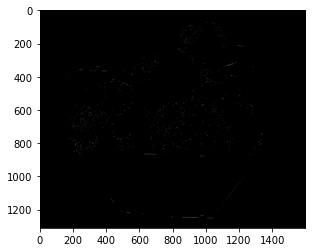

In [110]:
img = plt.imread('bowl-of-fruit.jpg')
sigma = 5.
h_ratio = 0.1
l_ratio = 0.08
img_temp = MyCannyFull(img, sigma, h_ratio, l_ratio) 
# input parameters: image matrix, standard deviation for gaussian blur(float), threshold ratio 
plt.imshow(img_temp, cmap = 'gray')

In [111]:
plt.imsave('myCannyFull.jpg', img_temp, cmap = 'gray')

### Seam Carving

In [22]:
img = plt.imread('York.jpg') #input of York image

In [23]:
def CarvingHelper(img, flag):
    t_rgb: torch.tensor = K.image_to_tensor(img)
    t_rgb = t_rgb.unsqueeze(0)
    img_rgb: np.array = K.tensor_to_image(t_rgb)
    plt.imshow(img_rgb)
    t_grad: torch.tensor = K.filters.spatial_gradient(t_rgb.float(), order = 1)
    t_grad_x = t_grad[:, :, 0, :]
    t_grad_y = t_grad[:, :, 1, :]
    t_grad_x = torch.pow(t_grad_x, 2)
    t_grad_y = torch.pow(t_grad_y, 2)
    t_energy = torch.sqrt(t_grad_x + t_grad_y)
    t_energy = torch.sum(t_energy, dim = 1)
    energy: np.array = K.tensor_to_image(t_energy)
    M = energy.copy()
    row_num = img.shape[0]
    col_num = img.shape[1]
    #dynamic programming
    for r in range(1, row_num):
        for c in range(0, col_num):
            if c == 0: #at the left edge of image
                M[r, c] = energy[r, c] + min(M[r - 1, c], M[r - 1, c + 1])
            elif c == col_num - 1: #at the right edge of image
                M[r, c] = energy[r, c] + min(M[r - 1, c - 1], M[r - 1, c])
            else:
                M[r, c] = energy[r, c] + min(M[r - 1, c - 1], M[r - 1, c], M[r - 1, c + 1])

    #create the shortest path of minimum energy sum
    path = []
    #find the index of the minimum sum of energy in the last row
    col_min = np.argmin(M[row_num - 1])
    path.append(col_min)
    #backtracking from bottom row to top row
    for r in range(1, row_num):
        col_min = path[-1] # the minimum energy of the previous row
        if col_min == 0: # edge case
            #find next minimum
            mins = min(M[row_num - r][col_min], M[row_num - r][col_min + 1])
            #keep track of the index and avoiding taking the duplicates as next min
            if mins == M[row_num - r][col_min + 1]: 
                path.append(col_min + 1)
            elif mins == M[row_num - r][col_min]:
                path.append(col_min)
        elif(col_min == col_num - 1): # edge case
            mins = min(M[row_num - r][col_min], M[row_num - r][col_min - 1])
            #keep track of the index and avoiding taking the duplicates as next min
            if mins == M[row_num - r][col_min]:
                path.append(col_min)
            elif mins == M[row_num - r][col_min - 1]:
                path.append(col_min - 1)
        else:
            mins = min(M[row_num - r][col_min], M[row_num - r][col_min + 1],  M[row_num - r][col_min - 1])
            #keep track of the index and avoiding taking the duplicates as next min
            if mins == M[row_num - r][col_min]:
                path.append(col_min)
            elif mins == M[row_num - r][col_min - 1]:
                path.append(col_min - 1)
            elif mins == M[row_num - r][col_min + 1]:
                path.append(col_min + 1)
    print(img.shape) #used for track the progress of seam carving
    path = path[::-1]
    if(flag == 1):
        row_num = img.shape[0]
        col_num = img.shape[1]
        img_pt = np.zeros((row_num, col_num), dtype = np.float64)
        for r in range(0, row_num):
            img_pt[r, path[r]] = - 1.
        img_pt = np.array([img_pt, img_pt, img_pt])
        img_pt = np.stack(img_pt, axis = 2)
        result = img[img_pt != -1].reshape((row_num, col_num - 1, 3))
    else:
        result = np.zeros((row_num, col_num + 1, 3), dtype = np.float64)
        for row in range(0, row_num):
            seam = path[row]
            for c in range(0, 3): 
                if(seam == 0):
                    avg = np.sum(img[row, 0: 2, c])/3
                    result[row, 0, c] = avg
                    result[row, 1, c] = img[row, 0, c]
                    result[row, 2:col_num + 1, c] = img[row, 1:col_num, c]
                else:
                    avg = np.sum(img[row, seam - 1:seam + 1, c])/3
                    result[row, :seam, c] = img[row, :seam, c]
                    result[row, seam, c] = avg
                    result[row, seam + 1:col_num + 1, c] = img[row, seam:col_num, c]
    return result



In [24]:
def MySeamCarving(img, new_width, new_height):
    #remove seam vertically
    while(img.shape[1] > new_height):
        img = CarvingHelper(img, 1)
    #remove seam horizontally
    if(img.shape[0] > new_width):
        img = np.transpose(img, (1, 0, 2))
        while(img.shape[1] > new_width):
            img = CarvingHelper(img, 1)
        img = np.transpose(img, (1, 0, 2))
    #insert seam vertically
    while(img.shape[1] < new_height):
        img = CarvingHelper(img, 0)
    #insert seam horizontally
    if(img.shape[0] < new_width):
        img = np.transpose(img, (1, 0, 2))
        while(img.shape[1] < new_width):
            img = CarvingHelper(img, 0)
        img = np.transpose(img, (1, 0, 2))
    return img.astype(np.uint8)
        
    

(1151, 1728, 3)
(1151, 1727, 3)
(1151, 1726, 3)
(1151, 1725, 3)
(1151, 1724, 3)
(1151, 1723, 3)
(1151, 1722, 3)
(1151, 1721, 3)


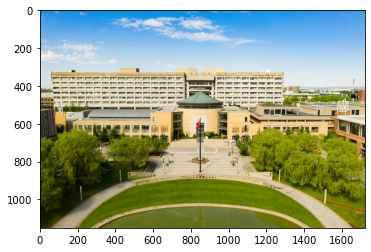

In [147]:
#Running for the resized image 1151*1200
img_v = MySeamCarving(img.copy(), 1151, 1720)
plt.imshow(img_v.astype(int))
plt.imsave('img_v.jpg', img_v)


(1728, 1151, 3)
(1728, 1150, 3)
(1728, 1149, 3)
(1728, 1148, 3)
(1728, 1147, 3)
(1728, 1146, 3)
(1728, 1145, 3)
(1728, 1144, 3)
(1728, 1143, 3)
(1728, 1142, 3)
(1728, 1141, 3)
(1728, 1140, 3)
(1728, 1139, 3)
(1728, 1138, 3)
(1728, 1137, 3)
(1728, 1136, 3)
(1728, 1135, 3)
(1728, 1134, 3)
(1728, 1133, 3)
(1728, 1132, 3)
(1728, 1131, 3)
(1728, 1130, 3)
(1728, 1129, 3)
(1728, 1128, 3)
(1728, 1127, 3)
(1728, 1126, 3)
(1728, 1125, 3)
(1728, 1124, 3)
(1728, 1123, 3)
(1728, 1122, 3)
(1728, 1121, 3)
(1728, 1120, 3)
(1728, 1119, 3)
(1728, 1118, 3)
(1728, 1117, 3)
(1728, 1116, 3)
(1728, 1115, 3)
(1728, 1114, 3)
(1728, 1113, 3)
(1728, 1112, 3)
(1728, 1111, 3)
(1728, 1110, 3)
(1728, 1109, 3)
(1728, 1108, 3)
(1728, 1107, 3)
(1728, 1106, 3)
(1728, 1105, 3)
(1728, 1104, 3)
(1728, 1103, 3)
(1728, 1102, 3)
(1728, 1101, 3)
(1728, 1100, 3)
(1728, 1099, 3)
(1728, 1098, 3)
(1728, 1097, 3)
(1728, 1096, 3)
(1728, 1095, 3)
(1728, 1094, 3)
(1728, 1093, 3)
(1728, 1092, 3)
(1728, 1091, 3)
(1728, 1090, 3)
(1728, 1

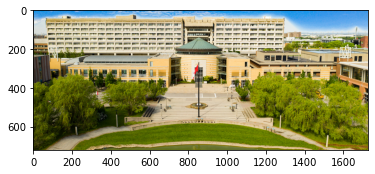

In [50]:
#Running for the resized image 1728*720
img_h = MySeamCarving(img.copy(), 720, 1728)
plt.imshow(img_h.astype(int))
plt.imsave('img_h.jpg', img_h)

(1210, 2048, 3)
(1210, 2048, 3)
(1210, 2047, 3)
(1210, 2046, 3)
(1210, 2045, 3)
(1210, 2044, 3)
(1210, 2043, 3)
(1210, 2042, 3)
(1210, 2041, 3)
(2040, 1210, 3)
(2040, 1209, 3)
(2040, 1208, 3)
(2040, 1207, 3)
(2040, 1206, 3)
(2040, 1205, 3)
(2040, 1204, 3)
(2040, 1203, 3)
(2040, 1202, 3)
(2040, 1201, 3)


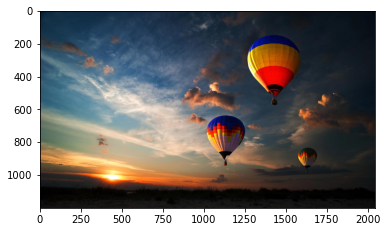

In [25]:
#Running for the resized my own image from 2048*1210 to 2040*1200
img_my = plt.imread('my_original.jpg')
print(img_my.shape)
img_v_my = MySeamCarving(img_my.copy(), 1200, 2040)
plt.imshow(img_v_my.astype(int))
plt.imsave('img_v_my.jpg',img_v_my)

(2048, 1210, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1211, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1212, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1213, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1214, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1215, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1216, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1217, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 1218, 3)
(2048, 1219, 3)


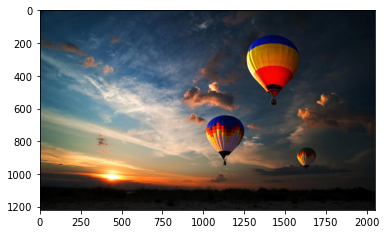

In [68]:
#Running for expanding my own image from 2048*1210 to 2040*1200
img_v_my = MySeamCarving(img_my.copy(), 1220, 2048)
plt.imshow(img_v_my.astype(int))
plt.imsave('img_v_my_expands.jpg', img_v_my)